In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp, linear_interp_1d

import Bargaining as brg

from figures import *

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 14
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

## Plot different cases

In [2]:
def plot_surplus_simple(Sw, Sm, grid_power, iP, title=None, ax=None):
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    
    
    ax.plot(grid_power,Sw, label='Woman', color=colors['red'])
    ax.plot(grid_power,Sm, label='Man', color=colors['blue'])
    ax.plot(grid_power,np.zeros(grid_power.size), color='black',linestyle='--') # add zero line
    
    #add vertical line at start_power
    start_power = grid_power[iP]
    ax.axvline(x=start_power, color=colors['gray'],linestyle='--', label='$\mu_{t-1}$')
    
    # Layout
    ax.set_xlabel('Power of woman')
    ax.set_ylabel('Marriage surplus')
    if title is not None:
        ax.set_title(title)
    ax.legend()


In [3]:
# generate fictive surplus functions
num_power = 200
grid_power = np.linspace(0, 1, num_power)

def never_happy(grid_power):
    return np.log(0.01+grid_power) - 0.1
def sometimes_happy_high(grid_power):
    return never_happy(grid_power) + 2
def sometimes_happy_low(grid_power):
    return never_happy(grid_power) + 0.5
def always_happy(grid_power):
    return never_happy(grid_power) + 5


w_never_happy = never_happy(grid_power)
w_always_happy = always_happy(grid_power)
w_sometimes_happy_high = sometimes_happy_high(grid_power)
w_sometimes_happy_low = sometimes_happy_low(grid_power)
power_at_zero_w_high = linear_interp_1d.interp_1d(w_sometimes_happy_high,grid_power, 0.0)

m_never_happy = np.flip(w_never_happy)
m_always_happy = np.flip(w_always_happy)
m_sometimes_happy_high = np.flip(w_sometimes_happy_high)
m_sometimes_happy_low = np.flip(w_sometimes_happy_low)
power_at_zero_m_high = 1-power_at_zero_w_high

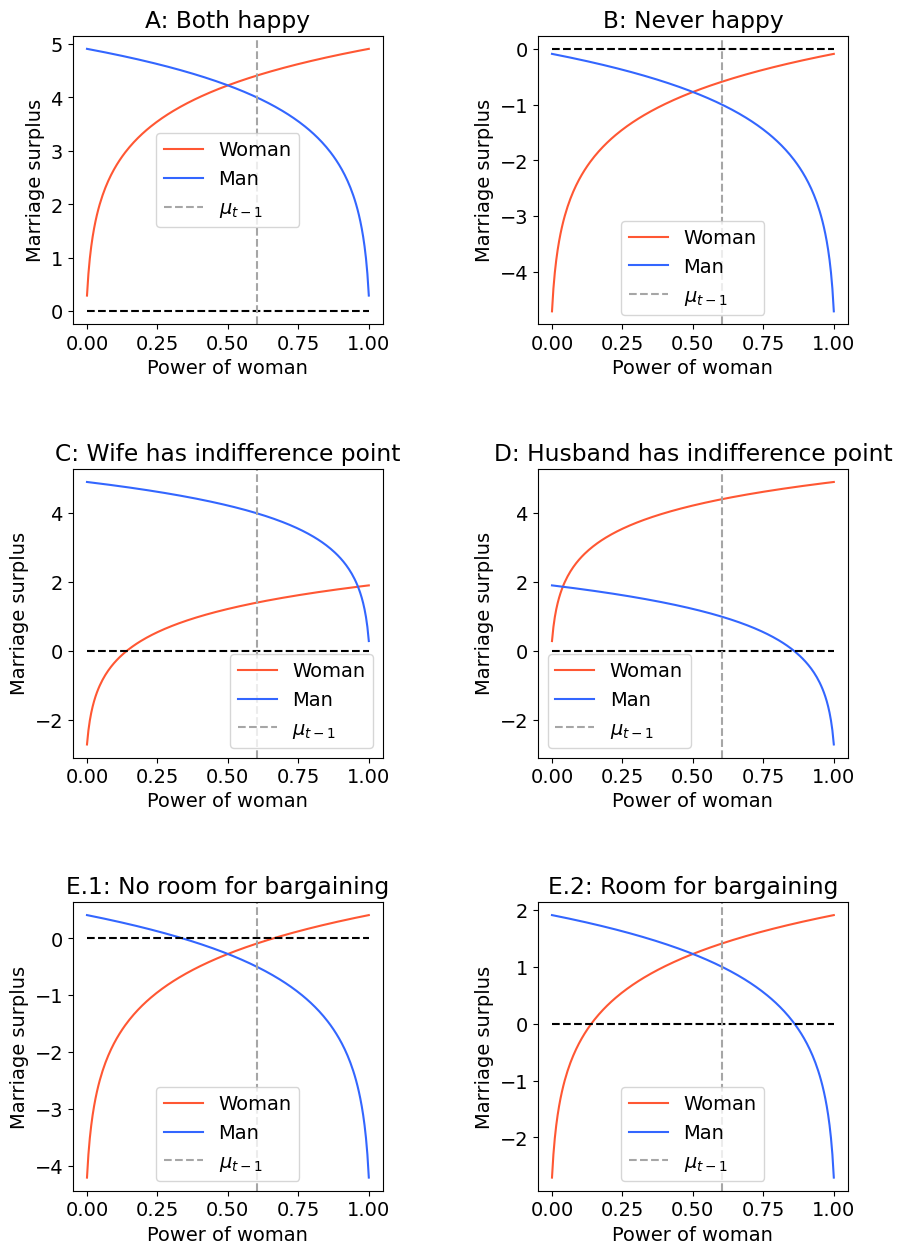

In [4]:
fig, axes = plt.subplots(3,2, figsize=(10,15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

iP = 120

# both happy
plot_surplus_simple(w_always_happy, m_always_happy, grid_power, iP, title='A: Both happy', ax=axes[0][0])

# never happy
plot_surplus_simple(w_never_happy, m_never_happy, grid_power, iP, title='B: Never happy', ax=axes[0][1])

# Wife sometimes happy, husband always happy
plot_surplus_simple(w_sometimes_happy_high, m_always_happy, grid_power, iP, title='C: Wife has indifference point', ax=axes[1][0])

# Wife always happy, husband sometimes happy
plot_surplus_simple(w_always_happy, m_sometimes_happy_high, grid_power, iP, title='D: Husband has indifference point', ax=axes[1][1])

# Both have indifference points, no room for bargaining
plot_surplus_simple(w_sometimes_happy_low, m_sometimes_happy_low, grid_power, iP, title='E.1: No room for bargaining', ax=axes[2][0])

# Both have indifference points, room for bargaining
plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, title='E.2: Room for bargaining', ax=axes[2][1])

## Illustrate interpolation

C:\Users\jmh520\AppData\Local\Temp\15\ipykernel_16460\3424071524.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(0.01+grid_power) - 0.1


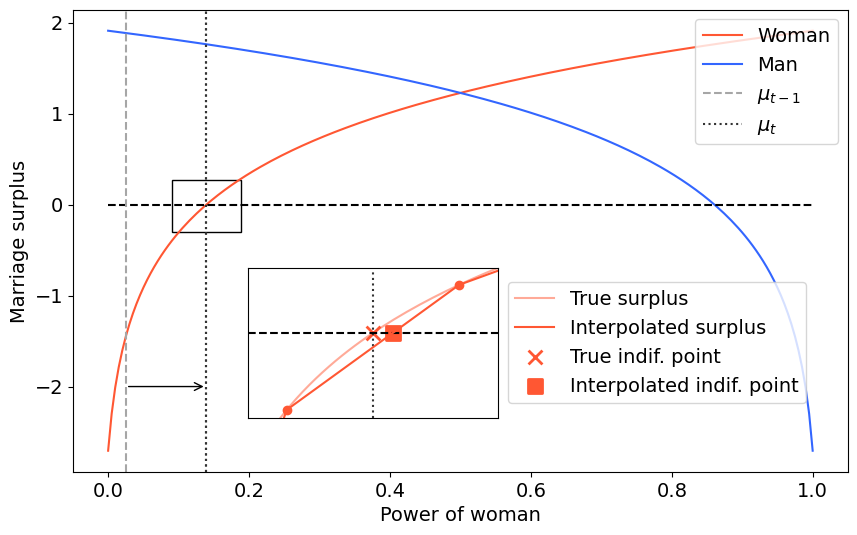

In [29]:
iP = 5

coarse_grid_power = np.linspace(power_at_zero_w_high-0.2, power_at_zero_w_high+0.2, 4)
coarse_w_sometimes_happy_high = sometimes_happy_high(coarse_grid_power)
if np.isnan(coarse_w_sometimes_happy_high[0]):
    coarse_w_sometimes_happy_high[0] = w_sometimes_happy_high[0]
    coarse_grid_power[0] = grid_power[0]

# make a plot
fig, ax = plt.subplots(figsize=(10,6))

plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, ax=ax)
ax.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='$\mu_{t}$')
ax.legend(loc='upper right')

# plot a vertical line at power_at_zero_w_high
ax.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='$\mu_{t}$')

# make a arrow pointing from the vertical line at iP to the vertical line at power_at_zero_w_high
ax.annotate("", xy=(power_at_zero_w_high, -2), xytext=(grid_power[iP], -2), arrowprops=dict(arrowstyle="->"))

# make an overlaying plot that focues on the vertical line at power_at_zero_w_high and place in the bottom right corner
min_x = coarse_grid_power[1]-0.03
max_x = coarse_grid_power[2]+0.03
x_range = max_x-min_x

min_y = -0.65
max_y = 0.5
y_range = max_y-min_y

left, bottom, width, height = [0.3, 0.2, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height]) # [left, bottom, width, height]
ax2.plot(grid_power, w_sometimes_happy_high, color=colors['red'], alpha=0.5, label='True surplus')
ax2.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='')
ax2.axhline(y=0, color='black',linestyle='--')
ax2.scatter(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'])
ax2.plot(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'], label='Interpolated surplus')

# remove all labels and titles from ax2
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# adjust limits of ax2
ax2.set_xlim([min_x, max_x])
ax2.set_ylim([min_y,max_y])

# make a box around the selected area in ax
rect = matplotlib.patches.Rectangle((min_x+0.25*x_range,min_y+0.3*y_range),x_range*0.5,y_range*0.5,linewidth=1,edgecolor='black',facecolor='none')
ax.add_patch(rect);


# scatter point at the true indifference point in ax2
ax2.scatter(power_at_zero_w_high, 0.0, color=colors['red'], marker='x', s=100, linewidth=2, label="True indif. point")

#scatter point at the interpolated indifference point in ax2
interp_power_at_zero = linear_interp_1d.interp_1d(coarse_w_sometimes_happy_high, coarse_grid_power, 0.0)
ax2.scatter(interp_power_at_zero, 0.0, color=colors['red'], marker='s', s=100, linewidth=2, label="Interpolated indif. point")

# place the legend for ax2 to the right of ax2
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5));